In [1]:
!pip install pandas numpy seaborn matplotlib scikit-learn pyspark kagglehub wordcloud

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, concat, lit, slice, rpad, when, size, array_repeat, explode, col, count, struct, array, concat_ws
from pyspark.sql.types import ArrayType, IntegerType, DoubleType
import kagglehub
import os
from pyspark.ml.feature import Tokenizer, StopWordsRemover, RegexTokenizer
from transformers import BertTokenizerFast
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import length
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark import SparkContext
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import ConfusionMatrixDisplay
from google.colab import files

In [3]:
files.upload() # Upload kaggle.json manually
os.makedirs("~/.kaggle")
os.rename("/content/kaggle.json", "~/.kaggle/kaggle.json")
path = kagglehub.dataset_download("kritanjalijain/amazon-reviews")

Saving kaggle.json to kaggle.json


In [4]:
print(path)

/kaggle/input/amazon-reviews


In [5]:
#Initialize Spark session
spark = SparkSession.builder.appName("AmazonReviewPolarity") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.executor.cores", "4") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.shuffle.spill", "true") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
print("Apache Spark Initialized Successfully!")

Apache Spark Initialized Successfully!


In [6]:
# Read data
train_df = spark.read.csv(f"{path}/train.csv", header=False, inferSchema=True)
test_df = spark.read.csv(f"{path}/test.csv", header=False, inferSchema=True)

In [7]:
#Rename columns
train_df_columns, test_df_columns = train_df.columns, test_df.columns

train_df = train_df.withColumnRenamed("_c0", "label") \
                   .withColumnRenamed("_c1", "title") \
                   .withColumnRenamed("_c2", "body")

test_df = test_df.withColumnRenamed("_c0", "label") \
                 .withColumnRenamed("_c1", "title") \
                 .withColumnRenamed("_c2", "body")

In [8]:
# Show 5 instances of data
train_df.show(5, truncate=100)
test_df.show(5, truncate=100)

+-----+------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|label|                                                 title|                                                                                                body|
+-----+------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|    2|                        Stuning even for the non-gamer|This sound track was beautiful! It paints the senery in your mind so well I would recomend it eve...|
|    2|                 The best soundtrack ever to anything.|I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'...|
|    2|                                              Amazing!|"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners...|
|    2|         

In [9]:
# Drop NA values in Data
train_df = train_df.dropna().dropDuplicates() \
             .withColumn("title", trim(col("title"))) \
             .withColumn("body", trim(col("body")))
test_df = test_df.dropna().dropDuplicates() \
             .withColumn("title", trim(col("title"))) \
             .withColumn("body", trim(col("body")))

In [10]:
train_df_try = train_df
test_df_try = test_df

In [11]:
# Perform initial data cleaning
train_df_cleaned = train_df.dropna().dropDuplicates() \
    .withColumn("title", trim(col("title"))) \
    .withColumn("body", trim(col("body")))

In [12]:
# Repartition the cleaned training DataFrame
train_partitioned_df = train_df_cleaned.repartition(5)

In [13]:
# Find number of records in each partition
train_partition_sizes = train_partitioned_df.rdd.glom().map(len).collect()


Training Data Distribution Across Partitions:
[719932, 719931, 719920, 719917, 719922]


<ipython-input-14-ab8e8215ec0b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, len(train_partition_sizes) + 1)),


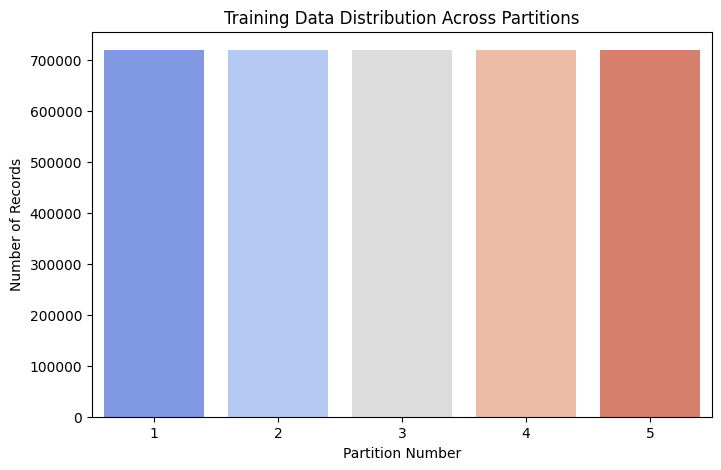

In [14]:
# Plot the number of instances in each partition

print("\nTraining Data Distribution Across Partitions:")
print(train_partition_sizes)

plt.figure(figsize=(8, 5))
sns.barplot(x=list(range(1, len(train_partition_sizes) + 1)),
            y=train_partition_sizes, palette='coolwarm')
plt.xlabel("Partition Number")
plt.ylabel("Number of Records")
plt.title("Training Data Distribution Across Partitions")
plt.show()

In [15]:
# Replace classes of 1 and 2 with 0 and 1 for easier interpretation
train_df = train_df.withColumn("label", when(col("label") == 1, 0).otherwise(1))
test_df = test_df.withColumn("label", when(col("label") == 1, 0).otherwise(1))
train_df.select("label").distinct().show()
test_df.select("label").distinct().show()

+-----+
|label|
+-----+
|    1|
|    0|
+-----+

+-----+
|label|
+-----+
|    1|
|    0|
+-----+



In [16]:
# Print first 5 rows to confirm the change
train_df.show(5, truncate=50)
test_df.show(5, truncate=100)

+-----+--------------------------------------------------+--------------------------------------------------+
|label|                                             title|                                              body|
+-----+--------------------------------------------------+--------------------------------------------------+
|    0|                                        NOT FUNNY!|This is what Hollywood is calling humor these d...|
|    0|                                    Edge of Danger|Somebody from higher places should have stopped...|
|    1|                       Great classic for the price|For a first time reading of this classic I reco...|
|    1|                                         Great Buy|I was looking for clarity and a picture that wo...|
|    0|The adapter shown is not the one that was shipped.|I received a different adapter so I cannot real...|
+-----+--------------------------------------------------+--------------------------------------------------+
only showi

In [17]:
# Make all words small letter for making tokenization better in later part
train_df = train_df.withColumn("title_lower", lower(col("title"))) \
    .withColumn("body_lower", lower(col("body")))

test_df = test_df.withColumn("title_lower", lower(col("title"))) \
    .withColumn("body_lower", lower(col("body")))

In [18]:
# Tokenize the title
tokenizer_title = RegexTokenizer(inputCol="title_lower", outputCol="title_tokens", pattern="\\W+")
train_df = tokenizer_title.transform(train_df)
test_df = tokenizer_title.transform(test_df)

In [19]:
# Tokenize the body

tokenizer_body = RegexTokenizer(inputCol="body_lower", outputCol="body_tokens", pattern="\\W+")
train_df = tokenizer_body.transform(train_df)
test_df = tokenizer_body.transform(test_df)

In [20]:
# Remove stop words from title
stop_words_remover_title = StopWordsRemover(inputCol="title_tokens", outputCol="title_clean")
train_df = stop_words_remover_title.transform(train_df)
test_df = stop_words_remover_title.transform(test_df)

In [21]:
# Remove stop words from body
stop_words_remover_body = StopWordsRemover(inputCol="body_tokens", outputCol="body_clean")
train_df = stop_words_remover_body.transform(train_df)
test_df = stop_words_remover_body.transform(test_df)

In [22]:
train_df.show(5, truncate=100)
test_df.show(5, truncate=100)

+-----+--------------------------------------------------+----------------------------------------------------------------------------------------------------+--------------------------------------------------+----------------------------------------------------------------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------+------------------------------+----------------------------------------------------------------------------------------------------+
|label|                                             title|                                                                                                body|                                       title_lower|                                                                                          body_lower|                                                title_tokens|                      

In [23]:
# Exploratory Data Analysis (EDA)

# Sample some data for word cloud
data = train_df.select("title_clean", "body_clean", "label",'body_tokens').sample(0.01).toPandas()

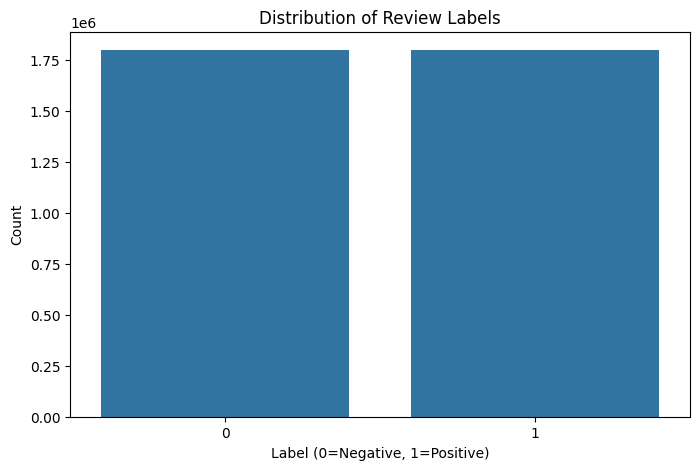

In [24]:
# Label Distribution
label_counts = train_df.groupBy("label").count().toPandas()
plt.figure(figsize=(8, 5))
sns.barplot(x='label', y='count', data=label_counts)
plt.title('Distribution of Review Labels')
plt.xlabel('Label (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.show()


<ipython-input-25-39c1cb1f7eec>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frequencies), y=list(tokens), palette='husl')  # Changed palette


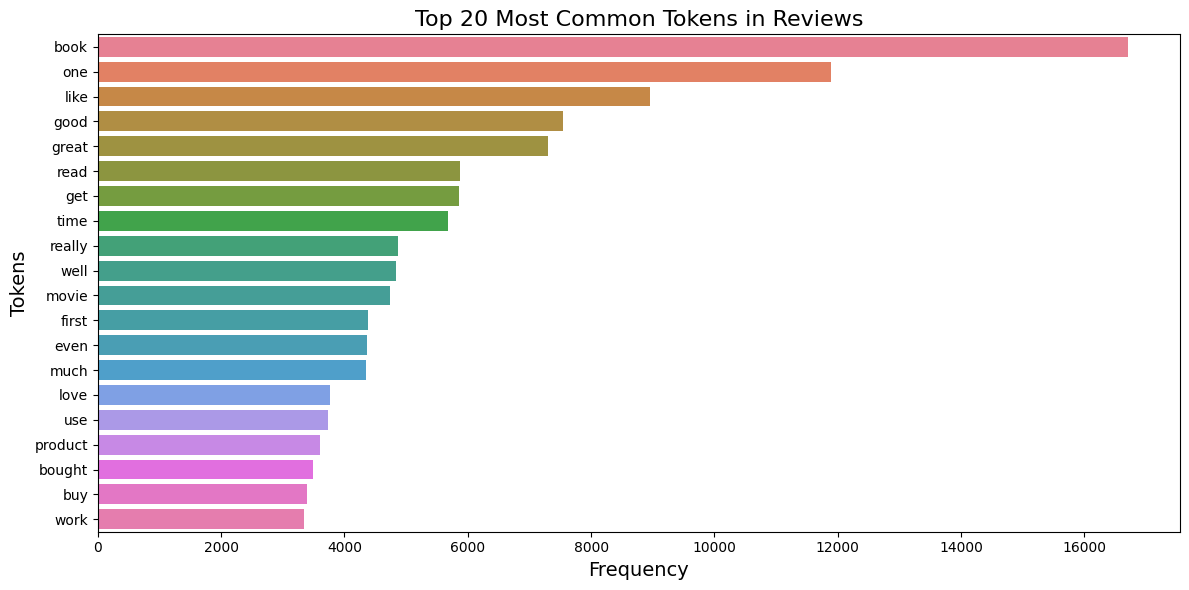

In [25]:
# Combine all tokens into a single list
all_tokens = [token for tokens in data['body_clean'] for token in tokens]

# Count the frequency of tokens
token_counts = Counter(all_tokens)

# Get the top 20 most common tokens
common_tokens = token_counts.most_common(20)  # Limiting to top 20

# Separate tokens and their frequencies
tokens, frequencies = zip(*common_tokens)

# Create a bar plot for the most frequent tokens
plt.figure(figsize=(12, 6))
sns.barplot(x=list(frequencies), y=list(tokens), palette='husl')  # Changed palette
plt.title('Top 20 Most Common Tokens in Reviews', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Tokens', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.grid(False)
plt.show()

<ipython-input-26-a87b6da2486e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=positive_words, palette='mako')
<ipython-input-26-a87b6da2486e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=negative_words, palette='rocket')


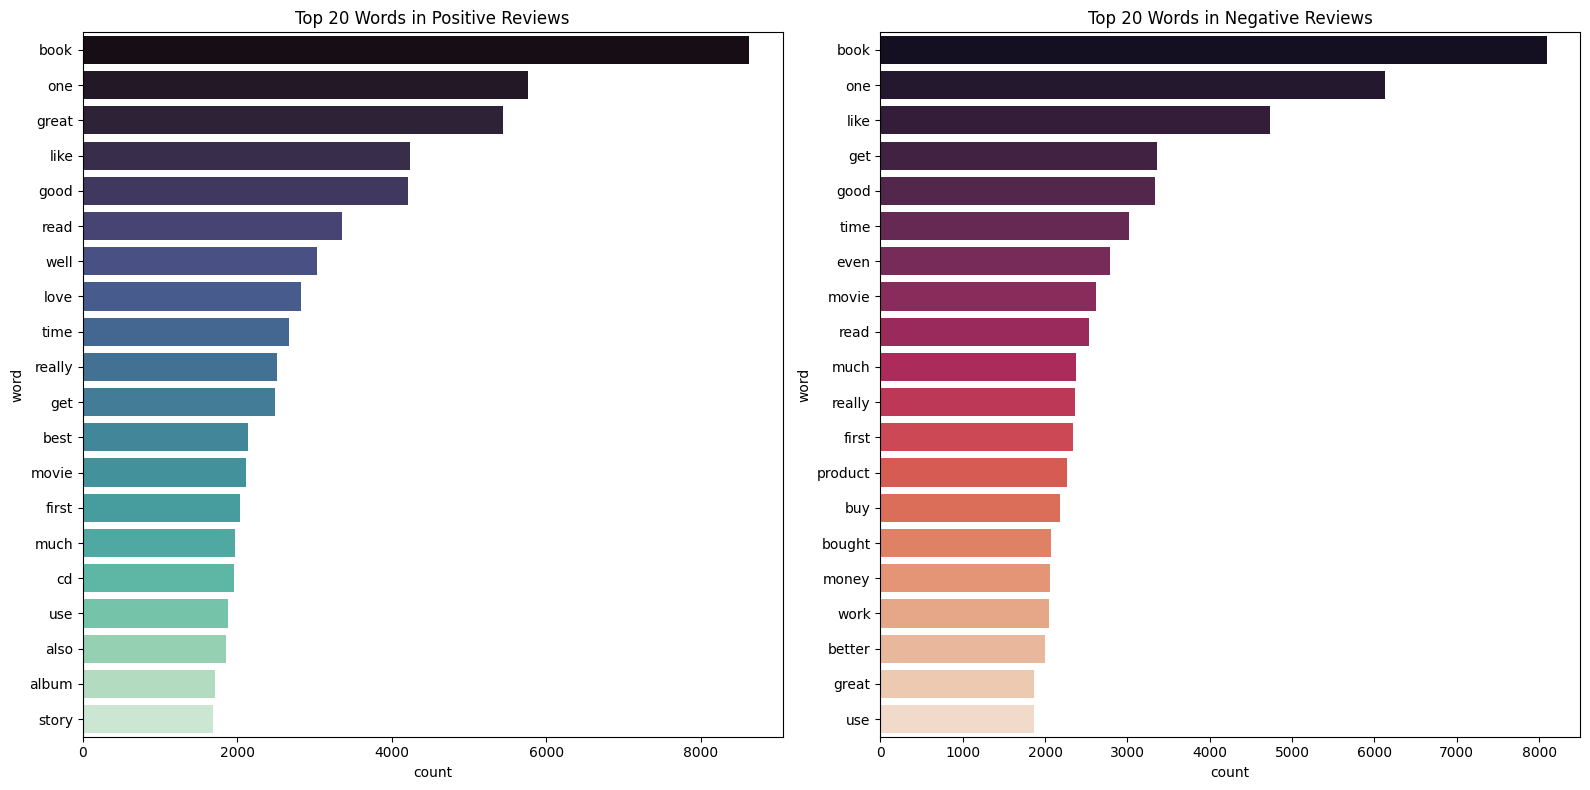

In [26]:
positive_tokens = [token for tokens in data[data['label'] == 1]['body_clean'] for token in tokens]
negative_tokens = [token for tokens in data[data['label'] == 0]['body_clean'] for token in tokens]

# Get top N words
top_n = 20
positive_counts = Counter(positive_tokens).most_common(top_n)
negative_counts = Counter(negative_tokens).most_common(top_n)

# Convert to DataFrames
positive_words = pd.DataFrame(positive_counts, columns=['word', 'count'])
negative_words = pd.DataFrame(negative_counts, columns=['word', 'count'])

# Create the visualization (same as above)
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.barplot(x='count', y='word', data=positive_words, palette='mako')
plt.title(f'Top {top_n} Words in Positive Reviews')

plt.subplot(1, 2, 2)
sns.barplot(x='count', y='word', data=negative_words, palette='rocket')
plt.title(f'Top {top_n} Words in Negative Reviews')

plt.tight_layout()
plt.show()

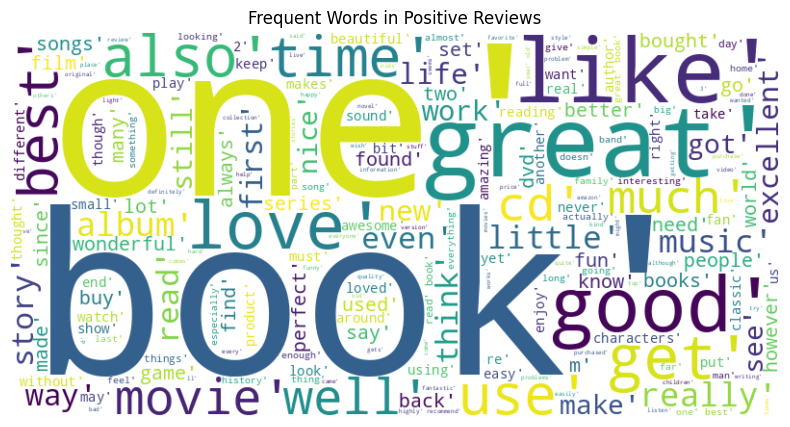

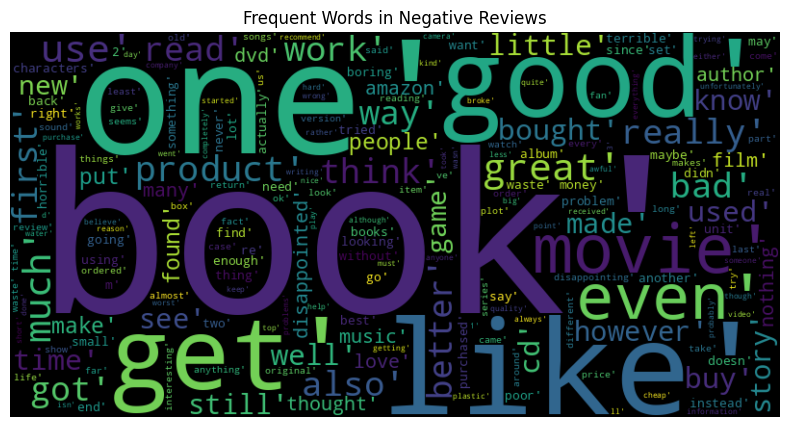

In [27]:
# Positive reviews word cloud
positive_text = ' '.join(data[data['label'] == 1]['title_clean'].astype(str)) + ' ' + ' '.join(data[data['label'] == 1]['body_clean'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Words in Positive Reviews')
plt.show()

# Negative reviews word cloud
negative_text = ' '.join(data[data['label'] == 0]['title_clean'].astype(str)) + ' ' + ' '.join(data[data['label'] == 0]['body_clean'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Words in Negative Reviews')
plt.show()

In [28]:
# Machine Learning Model (Logistic Regression)

# Create a pipeline with TF-IDF and Logistic Regression
cv = CountVectorizer(inputCol="body_clean", outputCol="raw_features", vocabSize=5000)
idf = IDF(inputCol="raw_features", outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="label")

pipeline = Pipeline(stages=[cv, idf, lr])

# Train the model
model = pipeline.fit(train_df)

# Make predictions
predictions = model.transform(test_df)

# Show some predictions
predictions.select("title", "body", "label", "prediction", "probability").show(5, truncate=50)

+-----------------------------------------+--------------------------------------------------+-----+----------+-----------------------------------------+
|                                    title|                                              body|label|prediction|                              probability|
+-----------------------------------------+--------------------------------------------------+-----+----------+-----------------------------------------+
|  Unique Weird Orientalia from the 1930's|"Exotic tales of the Orient from the 1930's. ""...|    1|       1.0|   [0.455325351782864,0.5446746482171361]|
|Heads above the first book in the trilogy|I was so disappointed in the first book, Founda...|    1|       0.0| [0.9154147122303966,0.08458528776960339]|
| Persuasive book with an unusual approach|The book details many or most of the important ...|    1|       1.0|[0.012930046639659224,0.9870699533603408]|
|                     Great Bed for Guests|Bought this for my Grandson to sl

In [29]:
predictions = predictions.withColumn("prediction", predictions["prediction"].cast(DoubleType()))
predictions = predictions.withColumn("label", predictions["label"].cast(DoubleType()))
predictions = predictions.withColumn("pred_label", struct("prediction", "label"))
metrics = MulticlassMetrics(predictions.select("pred_label").rdd.flatMap(lambda x:x))

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


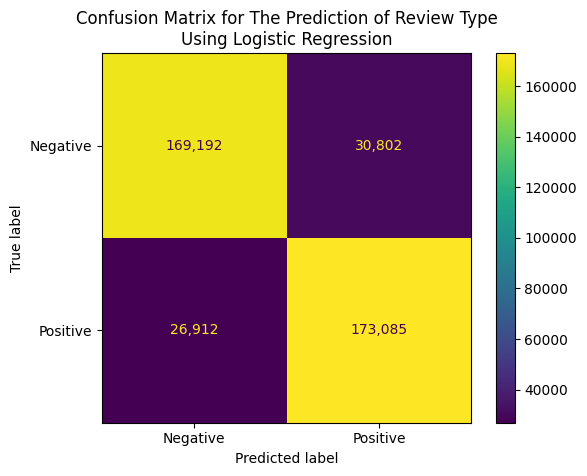

In [30]:
#Display confusion matrix
ConfusionMatrixDisplay(
    metrics.confusionMatrix().toArray(),
    display_labels = ["Negative", "Positive"]
).plot(values_format=",.0f")
plt.title("Confusion Matrix for The Prediction of Review Type\nUsing Logistic Regression")
plt.show()

In [31]:
print(f'''
Accuracy = {metrics.accuracy}
F-Measure = {metrics.fMeasure(1.0)}
Precision = {metrics.precision(1.0)}
Recall (Sensitivity) = {metrics.recall(1.0)}
False Positive Rate (1-Specificity) = {metrics.falsePositiveRate(1.0)}
''')


Accuracy = 0.855711753514454
F-Measure = 0.8571025343910628
Precision = 0.8489261208414465
Recall (Sensitivity) = 0.8654379815697235
False Positive Rate (1-Specificity) = 0.15401462043861316

